# [G-6] 모든 장르 간 편향성 측정해 보기

In [70]:
from gensim.models import Word2Vec
from konlpy.tag import Okt
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
from numpy import dot
from numpy.linalg import norm

import os

## STEP 1. 형태소 분석기를 이용하여 품사가 명사인 경우 해당 단어를 추출하기

### data 가져오기

In [16]:
with open(os.getenv('HOME')+'/aiffel/weat/synopsis.txt', 'r') as file:
    for i in range(20):
        print(file.readline(), end='')

사운드 엔지니어 상우(유지태 분)는 치매에 걸린 할머니(백성희 분)와
 젊은 시절 상처한 한 아버지(박인환 분), 고모(신신애 분)와 함께 살고 있다.
 어느 겨울 그는 지방 방송국 라디오 PD 은수(이영애 분)를 만난다.
 자연의 소리를 채집해 틀어주는 라디오 프로그램을 준비하는 은수는 상우와 녹음 여행을 떠난다.
 자연스레 가까워지는 두 사람은 어느 날, 은수의 아파트에서 밤을 보낸다.
 너무 쉽게 사랑에 빠진 두 사람... 상우는 주체할 수 없을 정도로 그녀에게 빨려든다.
 그러나 겨울에 만난 두 사람의 관계는 봄을 지나 여름을 맞이하면서 삐걱거린다.
 이혼 경험이 있는 은수는 상우에게 결혼할 생각이 없다며 부담스러운 표정을 내비친다.
 "어떻게 사랑이 변하니?..."라고 묻는 상우에게 은수는 그저 "헤어져" 라고 단호하게 말한다.
 영원히 변할 것 같지 않던 사랑이 변하고, 그 사실을 받아들이지 못하는 상우는 어찌 할 바를 모른다.
 은수를 잊지 못하는 상우는 미련과 집착의 감정을 이기지 못하고 서울과 강릉을 오간다.
유사 이래 연령, 성별, 빈부의 차이와 정치적인 입장을 불문하고 일거에 국민을 통합해 온 '애국심'이라는 성역에 일침을 가하는 다큐멘터리. 재작년 전국 민족민주 유가족협의회의 장기농성을 다룬 인상적인 다큐멘터리 <민들레>를 만들었던 독립영화집단 '빨간 눈사람'이 우리 사회 구석구석을 발빠르게 돌아다니며 애국심과 민족주의가 강요되는 현장을 발굴하여 카메라에 담았다. 박홍 서강대 명예총장, 이도형 '한국논단' 발행인, 축구해설자 신문선, 홍세화, 박노해 등 사회 각계의 '스타'들이 등장해 저마다의 확고한 신념을 성토한다. 감독 이경순과 최하동하는 이 작품을 위해 3년간 백여 명을 인터뷰했다고 한다. 2001 올해의 독립영화상 수상.
 민족과 국가란 공동체에서 부단히 권력과 부를 얻는 자, 나아가 민족과 국가란 공동체에서 얻은 신분과 부귀를 영원히 그의 자손에게 대물림하려는 자, 그래서 민족과 국가란 공동체를 부단히 유지해야만 하는 자, 따라서

### 형태소 분석기로 단어 추출(명사)

In [20]:
okt = Okt()
tokenized = []
with open(os.getenv('HOME')+'/aiffel/weat/synopsis.txt', 'r') as file:
    while True:
        line = file.readline()
        if not line: break # 추출을 다 끝내고 남은 line이 없다면 while문 탈출
        words = okt.pos(line, stem=True, norm=True)
        res = []
        for w in words:
            if w[1] in ["Noun"]: # Noun = 명사 / tokenized 된 단어가 명사라면
                res.append(w[0])    # res list 에 명사단어만 저장
        tokenized.append(res) # 저장된 res list (명사) 를 tokenized list로 다시 저장

In [21]:
print(len(tokenized))

71156


## STEP 2. 추출된 결과로 embedding model 만들기

In [25]:
model = Word2Vec(tokenized, vector_size=100, window=5, min_count=3, sg=0) # embedding (Word2Vec) model 구현

In [76]:
model.wv.most_similar(positive=['서사'])

[('요소', 0.970000684261322),
 ('내러티브', 0.9686278700828552),
 ('활용', 0.9641552567481995),
 ('기반', 0.9640387296676636),
 ('맥락', 0.963200569152832),
 ('완결', 0.9592462778091431),
 ('모티브', 0.9582203030586243),
 ('결합', 0.9575818777084351),
 ('서스펜스', 0.9541871547698975),
 ('매체', 0.954150915145874)]

In [75]:
model.wv.most_similar(positive=['액션'])

[('리얼', 0.8863986134529114),
 ('시대극', 0.8809728026390076),
 ('퍼포먼스', 0.8737539649009705),
 ('블록버스터', 0.8706073760986328),
 ('탄생', 0.8697410225868225),
 ('스릴러', 0.8676140308380127),
 ('비하인드', 0.867383599281311),
 ('호러', 0.8620800375938416),
 ('요소', 0.8613294363021851),
 ('구성', 0.8604877591133118)]

## STEP 3. target, attribute 단어 셋 만들기

In [33]:
def read_token(file_name):
    okt = Okt()
    result = []
    with open(os.getenv('HOME')+'/aiffel/weat/'+file_name, 'r') as fread: 
        print(file_name, '파일을 읽고 있습니다.')
        while True:
            line = fread.readline() 
            if not line: break 
            tokenlist = okt.pos(line, stem=True, norm=True) 
            for word in tokenlist:
                if word[1] in ["Noun"]:#, "Adjective", "Verb"]:
                    result.append((word[0])) 
    return ' '.join(result)

In [43]:
art_txt = 'synopsis_art.txt'
gen_txt = 'synopsis_gen.txt'

In [44]:
art = read_token(art_txt)
gen = read_token(gen_txt)

synopsis_art.txt 파일을 읽고 있습니다.
synopsis_gen.txt 파일을 읽고 있습니다.


In [45]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform([art, gen])

print(X.shape)

(2, 41082)


In [48]:
print(vectorizer.vocabulary_['과일'])
print(vectorizer.get_feature_names()[2230])

2230
과일


In [49]:
m1 = X[0].tocoo() # art
m2 = X[1].tocoo() # gen

w1 = [[i, j] for i, j in zip(m1.col, m1.data)]
w2 = [[i, j] for i, j in zip(m2.col, m2.data)]

w1.sort(key=lambda x: x[1], reverse=True) #art를 구성하는 단어들을 TF-IDF가 높은 순으로 정렬
w2.sort(key=lambda x: x[1], reverse=True) #gen을 구성하는 단어들을 TF-IDF가 높은 순으로 정렬

print('예술영화를 대표하는 단어들:')
for i in range(100):
    print(vectorizer.get_feature_names()[w1[i][0]], end=', ')

print('\n')
    
print('일반영화를 대표하는 단어들:')
for i in range(100):
    print(vectorizer.get_feature_names()[w2[i][0]], end=', ')

예술영화를 대표하는 단어들:
그녀, 자신, 시작, 위해, 사랑, 사람, 영화, 친구, 남자, 가족, 이야기, 마을, 사건, 마음, 세상, 아버지, 아이, 엄마, 모든, 여자, 대한, 서로, 과연, 다시, 시간, 아들, 소녀, 아내, 다른, 사이, 영화제, 세계, 사실, 하나, 점점, 남편, 감독, 여행, 인생, 발견, 모두, 순간, 우리, 가장, 마지막, 생활, 아빠, 모습, 통해, 죽음, 기억, 비밀, 학교, 음악, 한편, 소년, 생각, 도시, 명의, 사고, 결혼, 전쟁, 때문, 위기, 이제, 최고, 이자, 과거, 일상, 경찰, 상황, 간다, 미국, 결심, 운명, 현실, 관계, 지금, 단편, 여인, 하루, 이름, 이후, 준비, 인간, 감정, 만난, 국제, 처음, 충격, 살인, 누구, 동안, 존재, 그린, 어머니, 연인, 계속, 동생, 작품, 

일반영화를 대표하는 단어들:
자신, 그녀, 영화제, 위해, 사람, 시작, 국제, 영화, 친구, 사랑, 남자, 이야기, 대한, 서울, 여자, 사건, 남편, 아이, 가족, 아버지, 다른, 마을, 시간, 엄마, 아들, 모든, 단편, 마음, 사실, 다시, 세계, 모습, 작품, 통해, 생각, 서로, 세상, 발견, 감독, 아내, 관계, 소녀, 사이, 하나, 우리, 애니메이션, 때문, 여성, 죽음, 과연, 점점, 인간, 생활, 한편, 결혼, 상황, 모두, 기억, 명의, 소년, 여행, 가장, 간다, 순간, 이제, 도시, 비밀, 학교, 과거, 가지, 이자, 경찰, 마지막, 미국, 동안, 전쟁, 주인공, 대해, 존재, 현실, 연출, 사고, 살인, 일상, 어머니, 계속, 사회, 인생, 다큐멘터리, 부문, 섹스, 최고, 바로, 동생, 의도, 하루, 위기, 계획, 정체, 한국, 

### 중복값 제거

In [50]:
n = 15
w1_, w2_ = [], []
for i in range(100):
    w1_.append(vectorizer.get_feature_names()[w1[i][0]])
    w2_.append(vectorizer.get_feature_names()[w2[i][0]])

# w1에만 있고 w2에는 없는, 예술영화를 잘 대표하는 단어를 15개 추출
target_art, target_gen = [], []
for i in range(100):
    if (w1_[i] not in w2_) and (w1_[i] in model.wv): target_art.append(w1_[i]) #w1_[i] 안에 w2_가 없는것을 조건으로 둬서 중복 제거
    if len(target_art) == n: break 

# w2에만 있고 w1에는 없는, 일반영화를 잘 대표하는 단어를 15개 추출
for i in range(100):
    if (w2_[i] not in w1_) and (w2_[i] in model.wv): target_gen.append(w2_[i])
    if len(target_gen) == n: break

In [55]:
print(target_art)
print(target_gen)

['아빠', '음악', '결심', '운명', '지금', '여인', '이름', '이후', '준비', '감정', '만난', '처음', '충격', '누구', '그린']
['서울', '애니메이션', '여성', '가지', '주인공', '대해', '연출', '사회', '다큐멘터리', '부문', '섹스', '바로', '의도', '계획', '정체']


In [34]:
genre_txt = ['synopsis_SF.txt', 'synopsis_family.txt', 'synopsis_show.txt', 'synopsis_horror.txt', 'synopsis_etc.txt', 
             'synopsis_documentary.txt', 'synopsis_drama.txt', 'synopsis_romance.txt', 'synopsis_musical.txt', 
             'synopsis_mystery.txt', 'synopsis_crime.txt', 'synopsis_historical.txt', 'synopsis_western.txt', 
             'synopsis_adult.txt', 'synopsis_thriller.txt', 'synopsis_animation.txt', 'synopsis_action.txt', 
             'synopsis_adventure.txt', 'synopsis_war.txt', 'synopsis_comedy.txt', 'synopsis_fantasy.txt']
genre_name = ['SF', '가족', '공연', '공포(호러)', '기타', '다큐멘터리', '드라마', '멜로로맨스', '뮤지컬', '미스터리', '범죄', '사극', '서부극(웨스턴)',
         '성인물(에로)', '스릴러', '애니메이션', '액션', '어드벤처', '전쟁', '코미디', '판타지']

In [35]:
genre = []
for file_name in genre_txt:
    genre.append(read_token(file_name))

synopsis_SF.txt 파일을 읽고 있습니다.
synopsis_family.txt 파일을 읽고 있습니다.
synopsis_show.txt 파일을 읽고 있습니다.
synopsis_horror.txt 파일을 읽고 있습니다.
synopsis_etc.txt 파일을 읽고 있습니다.
synopsis_documentary.txt 파일을 읽고 있습니다.
synopsis_drama.txt 파일을 읽고 있습니다.
synopsis_romance.txt 파일을 읽고 있습니다.
synopsis_musical.txt 파일을 읽고 있습니다.
synopsis_mystery.txt 파일을 읽고 있습니다.
synopsis_crime.txt 파일을 읽고 있습니다.
synopsis_historical.txt 파일을 읽고 있습니다.
synopsis_western.txt 파일을 읽고 있습니다.
synopsis_adult.txt 파일을 읽고 있습니다.
synopsis_thriller.txt 파일을 읽고 있습니다.
synopsis_animation.txt 파일을 읽고 있습니다.
synopsis_action.txt 파일을 읽고 있습니다.
synopsis_adventure.txt 파일을 읽고 있습니다.
synopsis_war.txt 파일을 읽고 있습니다.
synopsis_comedy.txt 파일을 읽고 있습니다.
synopsis_fantasy.txt 파일을 읽고 있습니다.


In [36]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(genre)

print(X.shape)

(21, 42191)


In [37]:
m = [X[i].tocoo() for i in range(X.shape[0])]

w = [[[i, j] for i, j in zip(mm.col, mm.data)] for mm in m]

for i in range(len(w)):
    w[i].sort(key=lambda x: x[1], reverse=True)
attributes = []
for i in range(len(w)):
    print(genre_name[i], end=': ')
    attr = []
    j = 0
    while (len(attr) < 15):
        if vectorizer.get_feature_names()[w[i][j][0]] in model.wv:
            attr.append(vectorizer.get_feature_names()[w[i][j][0]])
            print(vectorizer.get_feature_names()[w[i][j][0]], end=', ')
        j += 1
    attributes.append(attr)
    print()

SF: 위해, 

/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


자신, 지구, 시작, 사람, 인류, 인간, 미래, 우주, 그녀, 로봇, 세계, 모든, 박사, 우주선, 
가족: 엄마, 아빠, 가족, 영화제, 자신, 위해, 친구, 아주르, 아버지, 시작, 그녀, 아들, 마을, 국제, 낙타, 
공연: 오페라, 사랑, 토스카, 실황, 올레, 자신, 카바, 그녀, 공연, 오텔로, 리골레토, 백작, 프레, 베르디, 위해, 
공포(호러): 시작, 위해, 사람, 자신, 친구, 그녀, 사건, 공포, 발견, 죽음, 마을, 가족, 악령, 남자, 좀비, 
기타: 영화제, 국제, 서울, 단편, 영화, 자신, 사람, 이야기, 그녀, 남자, 위해, 시작, 사랑, 뉴미디어, 페스티벌, 
다큐멘터리: 영화제, 영화, 다큐, 국제, 다큐멘터리, 사람, 이야기, 대한, 자신, 감독, 위해, 서울, 우리, 시작, 세계, 
드라마: 자신, 영화제, 그녀, 사람, 사랑, 영화, 위해, 시작, 국제, 남자, 친구, 이야기, 엄마, 여자, 아버지, 
멜로로맨스: 그녀, 사랑, 자신, 시작, 남편, 남자, 여자, 사람, 친구, 섹스, 위해, 마음, 결혼, 서로, 아내, 
뮤지컬: 뮤지컬, 사랑, 에스메랄다, 그녀, 음악, 충무로, 모차르트, 영화, 토스카, 자신, 니웨, 카바, 영화제, 바흐, 페뷔스, 
미스터리: 사건, 그녀, 시작, 자신, 위해, 사람, 발견, 사고, 진실, 죽음, 기억, 살인, 친구, 아내, 남자, 
범죄: 사건, 위해, 자신, 경찰, 시작, 그녀, 범죄, 조직, 살인, 사람, 마약, 형사, 남자, 모든, 살해, 
사극: 조선, 위해, 시작, 신기전, 사랑, 자신, 아가멤논, 황제, 그녀, 루안, 최고, 운명, 사람, 하선, 전쟁, 
서부극(웨스턴): 서부, 보안관, 위해, 벌린, 카우보이, 그레이프바인, 헨리, 마을, 자신, 개릿, 아이, 시작, 무법자, 프린트, 마적, 
성인물(에로): 그녀, 남편, 마사지, 자신, 섹스, 관계, 영화, 정사, 남자, 위해, 시작, 여자, 유부녀, 마음, 사랑, 
스릴러: 자신, 그녀, 사건, 시작, 위해, 

## STEP 4. WEAT score 계산과 시각화

### weat score 구현

In [60]:
def cos_sim(i, j):
    return dot(i, j.T)/(norm(i)*norm(j))

def test(w, A, B):
    c_a = cos_sim(w, A)
    c_b = cos_sim(w, B)
    mean_A = np.mean(c_a, axis=-1)
    mean_B = np.mean(c_b, axis=-1)
    return mean_A - mean_B #, c_a, c_b

In [62]:
def weat_score(X, Y, A, B):
    
    test_X = test(X, A, B)
    test_Y = test(Y, A, B)

    mean_X = np.mean(test_X)
    mean_Y = np.mean(test_Y)
    
    std_dev = np.std(np.concatenate([test_X, test_Y], axis=0))
    
    return  (mean_X-mean_Y)/std_dev

In [39]:
matrix = [[0 for _ in range(len(genre_name))] for _ in range(len(genre_name))]

In [63]:
X = np.array([model.wv[word] for word in target_art])
Y = np.array([model.wv[word] for word in target_gen])

for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        A = np.array([model.wv[word] for word in attributes[i]])
        B = np.array([model.wv[word] for word in attributes[j]])
        matrix[i][j] = weat_score(X, Y, A, B)

In [64]:
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        print(genre_name[i], genre_name[j],matrix[i][j])

SF 가족 -0.4913624
SF 공연 -0.38815364
SF 공포(호러) -0.6812512
SF 기타 0.36396277
SF 다큐멘터리 0.5953653
SF 드라마 -0.33960694
SF 멜로로맨스 -0.77666265
SF 뮤지컬 0.32429913
SF 미스터리 -0.666635
SF 범죄 -0.21705703
SF 사극 -0.7954703
SF 서부극(웨스턴) -0.40548903
SF 성인물(에로) -0.5562861
SF 스릴러 -0.5173884
SF 애니메이션 0.36567408
SF 액션 -0.45527244
SF 어드벤처 -0.7786346
SF 전쟁 0.19544736
SF 코미디 -0.43599007
SF 판타지 -0.15876442
가족 공연 0.16554809
가족 공포(호러) -0.16538373
가족 기타 0.76247954
가족 다큐멘터리 0.83260804
가족 드라마 0.2617996
가족 멜로로맨스 -0.60710174
가족 뮤지컬 0.6809914
가족 미스터리 -0.28736869
가족 범죄 0.22208054
가족 사극 -0.043133847
가족 서부극(웨스턴) 0.4301838
가족 성인물(에로) -0.3001521
가족 스릴러 -0.13364117
가족 애니메이션 0.86395425
가족 액션 0.09737911
가족 어드벤처 -0.031132264
가족 전쟁 0.62085325
가족 코미디 0.20433357
가족 판타지 0.43274596
공연 공포(호러) -0.24110389
공연 기타 0.9303735
공연 다큐멘터리 0.91658634
공연 드라마 0.10157433
공연 멜로로맨스 -0.69487435
공연 뮤지컬 0.84998417
공연 미스터리 -0.33325392
공연 범죄 0.105896175
공연 사극 -0.30525827
공연 서부극(웨스턴) 0.09517709
공연 성인물(에로) -0.45841455
공연 스릴러 -0.20405324
공연 애니메이션 0.90338874
공연 액

<AxesSubplot:>

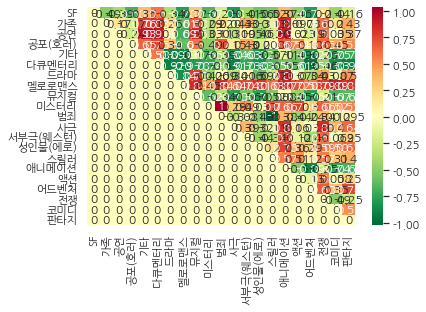

In [71]:
np.random.seed(0)

# 한글 지원 폰트
sns.set(font='NanumGothic')

# 마이너스 부호 
plt.rcParams['axes.unicode_minus'] = False

ax = sns.heatmap(matrix, xticklabels=genre_name, yticklabels=genre_name, annot=True,  cmap='RdYlGn_r')
ax

# Reference

Aiffel GoingDeeper 노드 6. 임베딩 내 편향성 알아보기

# 회고

이번 Going Deeper 노드에선 크게 문제 없이 노드 내용대로 따라가면서 하니  
정상적으로 잘 마무리 지을 수 있었습니다.  
이번 노드에서 이해하고 넘어갔던 내용은 임베딩 내 편향성을 어떻게 구하는지에 대해서  
대략적인 내용에 대해선 이해하고 넘어갔으며 편향성을 갖게 된다는것을 무시하지 못한다는것도  
알게되어 편향성에 대해서 좀더 생각하고 넘어갈 수 있었습니다.  
  
* STEP 1. 형태소 분석기를 이용하여 품사가 명사인 경우 해당 단어를 추출하기  
형태소 분석기로 konlpy 의 Okt(Open Korean Text) 모델을 사용하였으며 명사를 추출할 수 있는 함수를 지원하고 있어  
tokenized 를 하고 난 이후 if문을 활용하여 명사인 경우의 단어만 추출이 가능했습니다.(Noun)  
  
* STEP 2. 추출된 결과로 embedding model 만들기  
embedding model 로는 gensim 의 Word2Vec 모델을 사용했으며 vocab_size 는 노드에 나온 내용과 같은 100 사이즈와  
window 사이즈로는 5, 그리고 단어의 최소개수 min_count는 3으로 두고 모델을 학습 시켰습니다.  
  
* STEP 3. target, attribute 단어 셋 만들기  
target, attribute 으로 target은 synopsis_art.txt, synopsis_gen.txt (예술영화, 일반(상업)영화)  
attribute 는 장르로 나눠서 단어set을 만들었으며 sklearn 의 TfidfVectorizer 를 사용하여 단어 셋을 구성하였으며  
TfidfVectorizer 만으로는 중복값이 나올 수 있어 중복값 자체를 제거하는 함수를 if 문으로서 구현을 했고  
테스트를 진행하여 index 와 단어의 매칭이 잘 진행되었음을 확인했습니다.  
  
* STEP 4. WEAT score 계산과 시각화
WEAT score 값에 대한 함수는 각 데이터간의 cos_sim 값을 구하고 구한 cos_sim 값 끼리 평균값을 구함,  
그리고 마지막으로 평균값을 구한 데이터끼리의 - 를 이용하여 얼마나 데이터간에 편향성이 존재하는지를  
확인하는지 수식과 코드로서 확인했으며 WEAT score 를 이해하는데 많은 도움이 됐었던 것 같습니다.  
추가로 이해하고 넘어가는 것 뿐만이 아닌 시각화를 통해 어떤식으로 데이터가 보여지는지 확인을 직접 하기도 했습니다.